In [1]:
# ----------------------
# Load required packages
# ----------------------

import gc
import sys, getopt
import ujson as json
import random
import datetime
import argparse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters, VOC
from covid19model.models.time_dependant_parameter_fncs import ramp_fun
from covid19model.visualization.output import _apply_tick_locator 
# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
# -----------------------
# Load samples dictionary
# -----------------------

filename = 'BE_WAVE2_R0_COMP_EFF_2021-05-21.json'
# Path where MCMC samples are saved
samples_path = '../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/'

from covid19model.models.utils import load_samples_dict
samples_dict = load_samples_dict(samples_path+str(filename), wave=2)
warmup = int(samples_dict['warmup'])
start_calibration = samples_dict['start_calibration']
end_calibration = samples_dict['end_calibration']

In [3]:
# ---------
# Load data
# ---------

# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices()
levels = initN.size
# Sciensano data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False, plot=False)
# VOC data
df_VOC_501Y = VOC.get_501Y_data()

In [4]:
# ---------------------------
# Time-dependant VOC function
# ---------------------------

from covid19model.models.time_dependant_parameter_fncs import make_VOC_function
VOC_function = make_VOC_function(df_VOC_501Y)

# -----------------------------------
# Time-dependant vaccination function
# -----------------------------------

from covid19model.models.time_dependant_parameter_fncs import  make_vaccination_function
vacc_strategy = make_vaccination_function(df_sciensano).stratified_vaccination_strategy

# --------------------------------------
# Time-dependant social contact function
# --------------------------------------

# Extract build contact matrix function
from covid19model.models.time_dependant_parameter_fncs import make_contact_matrix_function, delayed_ramp_fun, ramp_fun
contact_matrix_4prev = make_contact_matrix_function(df_google, Nc_all)
policies_WAVE2_no_relaxation = make_contact_matrix_function(df_google, Nc_all).policies_WAVE2_no_relaxation

# -----------------------------
# Function to add poisson draws
# -----------------------------

from covid19model.models.utils import output_to_visuals
from covid19model.models.utils import draw_fcn_WAVE2_stratified_vacc as draw_fcn_WAVE2

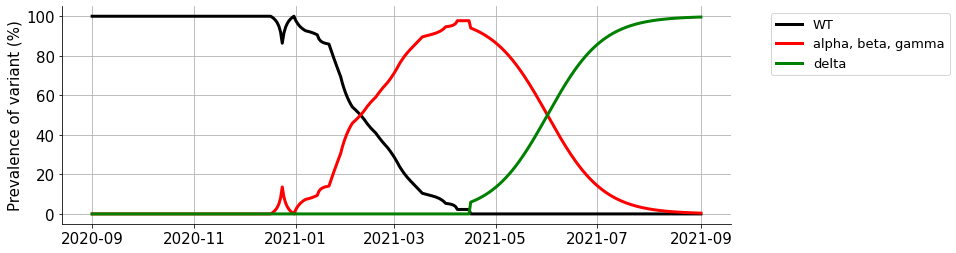

In [5]:
# ------------------
# Visualize variants
# ------------------

# Call VOC function and save data
dates = pd.date_range(start = '2020-09-01', end = '2021-09-01', freq='D')
k = 0.06
t_sig = '2021-06-01'
wt=[]
alpha=[]
delta=[]
for date in dates:
    wt.append(VOC_function(date, {},{},k,t_sig)[0])
    alpha.append(VOC_function(date, {},{},k,t_sig)[1])
    delta.append(VOC_function(date, {},{},k,t_sig)[2])

# Make figure
fig,ax=plt.subplots(figsize=(12,4))
ax.plot(dates,np.array(wt)*100, color='black')
ax.plot(dates,np.array(alpha)*100, color='red')
ax.plot(dates,np.array(delta)*100, color='green')
ax.set_ylabel('Prevalence of variant (%)')
ax.legend(['WT','alpha, beta, gamma','delta'], bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=13)    

In [6]:
# -------------------------------------
# Initialize the model with vaccination
# -------------------------------------

# Model initial condition on September 1st
with open('../../data/interim/model_parameters/COVID19_SEIRD/calibrations/national/initial_states_2020-09-01.json', 'r') as fp:
    initial_states = json.load(fp)  

In [7]:
# Correct size of initial states
entries_to_remove = ('S_v', 'E_v', 'I_v', 'A_v', 'M_v', 'C_v', 'C_icurec_v', 'ICU_v', 'R_v')
for k in entries_to_remove:
    initial_states.pop(k, None)

for key, value in initial_states.items():
    initial_states[key] = np.concatenate((np.expand_dims(initial_states[key],axis=1),np.ones([9,2])),axis=1) 

In [8]:
# Load the model parameters dictionary
params = model_parameters.get_COVID19_SEIRD_parameters(vaccination=True)
# Add "size dummy" for vaccination stratification
params.update({'doses': np.zeros([3,3])})
# Correct size of other parameters
params.update({'e_s': np.array([[0, 0.7, 0.95],[0, 0.7, 0.95],[0, 0.3, 0.85]])}) # rows = VOC, columns = # no. doses
params.update({'e_h': np.array([[0,0.7,0.95],[0,0.7,0.95],[0,0.7,0.95]])})
params.update({'e_a': np.array([[0,1,1],[0,1,1],[0,1,1]])})
params.update({'e_i': np.array([[0,0.7,0.95],[0,0.7,0.95],[0,0.7,0.95]])})                
params.update({'d_vacc': 31*36})
params.update({'N_vacc': np.zeros([9,3])})
params.pop('e_a')
# Add the time-dependant parameter function arguments
# Social policies
params.update({'l': 21, 'prev_schools': 0, 'prev_work': 0.5, 'prev_rest': 0.5, 'prev_home': 0.5})
# VOC
params.update({'k': 0.15, 't_sig': '2021-06-01'})
# Vaccination
params.update(
    {'initN': initN, 'vacc_order': np.array(range(9))[::-1], 'daily_first_dose': 55000,
     'refusal': 0.2*np.ones([9,2]), 'delay_immunity': 14, 'delay_doses': 3*7, 'stop_idx': 9}
)
# Initialize model
model = models.COVID19_SEIRD_stratified_vacc(initial_states, params,
                        time_dependent_parameters={'Nc': policies_WAVE2_no_relaxation, 'N_vacc': vacc_strategy, 'alpha': VOC_function})

In [9]:
# -------------------
# Perform simulations
# -------------------

n_samples = 100
n_draws_per_sample = 1
conf_int = 0.05
end_sim = '2022-01-01'

print('\n1) Simulating COVID-19 SEIRD '+str(n_samples)+' times')
start_sim = start_calibration
out = model.sim(end_sim,start_date=start_sim,warmup=warmup,N=n_samples,draw_fcn=draw_fcn_WAVE2,samples=samples_dict)
#simtime, df_2plot = output_to_visuals(out, ['H_in', 'H_tot', 'ICU', 'D', 'R'], n_samples, n_draws_per_sample, LL = conf_int/2, UL = 1 - conf_int/2)


1) Simulating COVID-19 SEIRD 100 times


Text(0.5, 1.0, '2 doses')

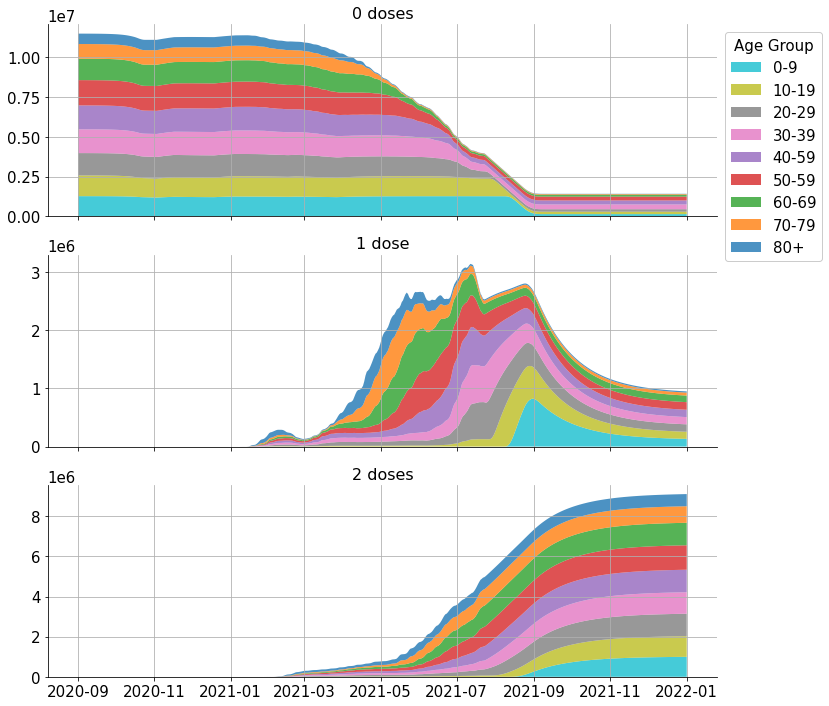

In [10]:
import matplotlib.cm as cm
Palette=cm.get_cmap('tab10_r', levels).colors
age_group=['0-9','10-19','20-29','30-39','40-59','50-59','60-69','70-79','80+']

fig,(ax1,ax2,ax3) = plt.subplots(figsize=(12,12), nrows=3, ncols=1, sharex=True)
simtime = out['time'].values
ax1.stackplot(simtime,out['S'].mean(dim='draws').isel(doses=0)+out['R'].mean(dim='draws').isel(doses=0), labels=age_group, colors=Palette, alpha=0.8)
ax1.legend(fancybox=True, frameon=True, framealpha=1, fontsize=15,title='Age Group', loc="upper left", bbox_to_anchor=(1,1))  
ax1.set_title('0 doses', fontsize=16)
ax2.stackplot(simtime,out['S'].mean(dim='draws').isel(doses=1)+out['R'].mean(dim='draws').isel(doses=1), labels=age_group, colors=Palette, alpha=0.8)
ax2.set_title('1 dose', fontsize=16)
ax3.stackplot(simtime,out['S'].mean(dim='draws').isel(doses=2)+out['R'].mean(dim='draws').isel(doses=2), labels=age_group, colors=Palette, alpha=0.8)
ax3.set_title('2 doses', fontsize=16)

(18506.0, 18993.0)

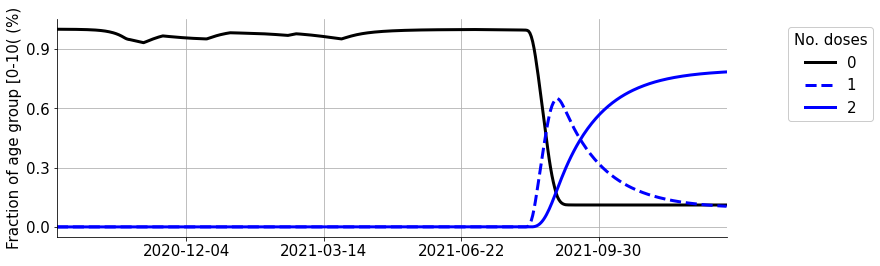

In [11]:
fig,ax = plt.subplots(figsize=(12,4))

T_start = (out['S'].mean(dim='draws').isel(doses=0).values[0]+out['R'].mean(dim='draws').isel(doses=0).values[0])[0]
dose_0 = out['S'].mean(dim='draws').isel(doses=0).values[0]+out['R'].mean(dim='draws').isel(doses=0).values[0]
dose_1 = out['S'].mean(dim='draws').isel(doses=1).values[0]+out['R'].mean(dim='draws').isel(doses=1).values[0]
dose_2 = out['S'].mean(dim='draws').isel(doses=2).values[0]+out['R'].mean(dim='draws').isel(doses=2).values[0]

ax.plot(simtime,dose_0/T_start, color='black', label='0')
ax.plot(simtime,dose_1/T_start, '--', color='blue', label='1')
ax.plot(simtime,dose_2/T_start, color='blue', label='2')

ax.set_ylabel('Fraction of age group [0-10( (%)')
ax.legend(fancybox=True, frameon=True, framealpha=1, fontsize=15,title='No. doses', loc="upper left", bbox_to_anchor=(1.08,1))

ax = _apply_tick_locator(ax)
ax.set_xlim('2020-09-01',end_sim)

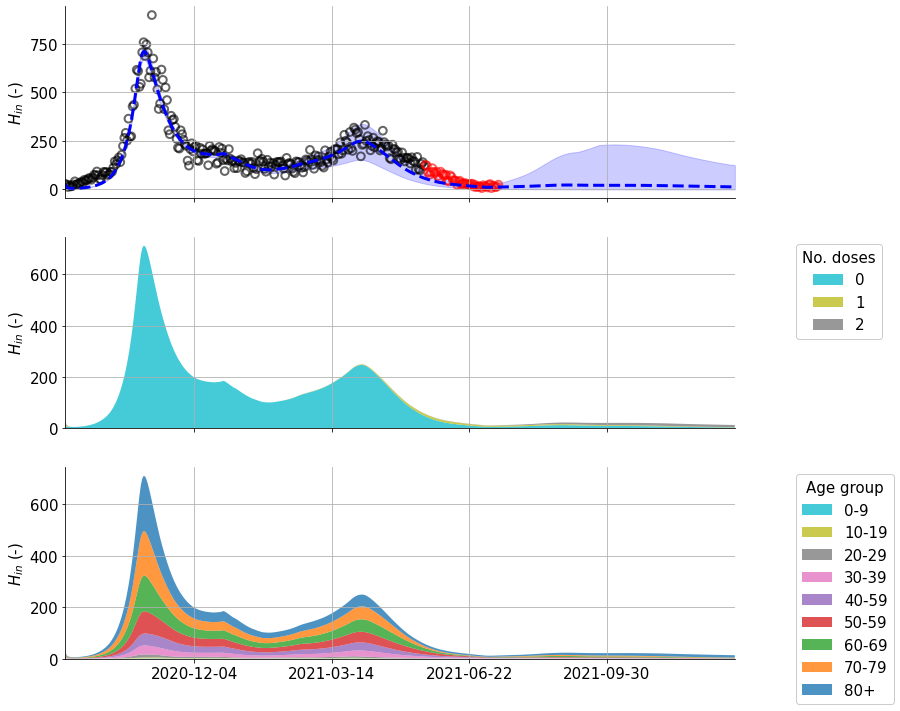

In [12]:
fig,(ax1,ax2,ax3) = plt.subplots(figsize=(12,12),nrows=3, ncols=1,sharex=True)

simtime = out['time'].values
ax1.plot(simtime,out['H_in'].sum(dim='Nc').sum(dim='doses').mean(dim='draws'), '--', color='blue')
ax1.fill_between(simtime,out['H_in'].sum(dim='Nc').sum(dim='doses').quantile(dim='draws',q=0.025), out['H_in'].sum(dim='Nc').sum(dim='doses').quantile(dim='draws',q=0.975), color='blue', alpha = 0.20)
ax1.scatter(df_sciensano[start_calibration:end_calibration].index,df_sciensano['H_in'][start_calibration:end_calibration], color='black', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax1.scatter(df_sciensano[pd.to_datetime(end_calibration)+datetime.timedelta(days=1):].index,df_sciensano['H_in'][pd.to_datetime(end_calibration)+datetime.timedelta(days=1):], color='red', alpha=0.6, linestyle='None', facecolors='none', s=60, linewidth=2)
ax1 = _apply_tick_locator(ax1)
ax1.set_xlim('2020-09-01',end_sim)
ax1.set_ylabel('$H_{in}$ (-)')

ax2.stackplot(simtime,out['H_in'].sum(dim='Nc').mean(dim='draws'), labels=['0', '1', '2'], colors=Palette, alpha=0.8 )
ax2.legend(fancybox=True, frameon=True, framealpha=1, fontsize=15,title='No. doses', loc="upper left", bbox_to_anchor=(1.08,1))
ax2 = _apply_tick_locator(ax2)
ax2.set_xlim('2020-09-01',end_sim)
ax2.set_ylabel('$H_{in}$ (-)')

ax3.stackplot(simtime,out['H_in'].sum(dim='doses').mean(dim='draws'), labels=age_group, colors=Palette, alpha=0.8 )
ax3.legend(fancybox=True, frameon=True, framealpha=1, fontsize=15,title='Age group', loc="upper left", bbox_to_anchor=(1.08,1))
ax3 = _apply_tick_locator(ax3)
ax3.set_xlim('2020-09-01',end_sim)
ax3.set_ylabel('$H_{in}$ (-)')

fig.savefig('multijab_prediction_vaccinate_all.jpg',bbox_inches='tight',dpi=400)